<a href="https://colab.research.google.com/github/Taehwan2/hanghaeAI/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


  ## 제출자료
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [3]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 470kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.18MB/s]


In [4]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [5]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

In [6]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [7]:
n_epochs = 100
loss_f = nn.CrossEntropyLoss()

train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_f(preds,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  train_accs.append(accuracy(model,trainloader))
  test_accs.append(accuracy(model,testloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 2143.3254244327545
Epoch   1 | Loss: 2095.021741628647
Epoch   2 | Loss: 2013.6324443817139
Epoch   3 | Loss: 1882.1834948062897
Epoch   4 | Loss: 1677.8840899467468
Epoch   5 | Loss: 1424.5303146839142
Epoch   6 | Loss: 1198.59733325243
Epoch   7 | Loss: 1039.3264940977097
Epoch   8 | Loss: 932.0208647847176
Epoch   9 | Loss: 855.9812100529671
Epoch  10 | Loss: 798.8989485502243
Epoch  11 | Loss: 754.0262841880322
Epoch  12 | Loss: 718.117290019989
Epoch  13 | Loss: 688.8292039334774
Epoch  14 | Loss: 664.6242877244949
Epoch  15 | Loss: 644.2099571824074
Epoch  16 | Loss: 626.7593925893307
Epoch  17 | Loss: 611.9264690577984
Epoch  18 | Loss: 598.9736837744713
Epoch  19 | Loss: 587.6267790198326
Epoch  20 | Loss: 577.6540677547455
Epoch  21 | Loss: 568.7689377963543
Epoch  22 | Loss: 560.7593844980001
Epoch  23 | Loss: 553.4967008382082
Epoch  24 | Loss: 546.8906198889017
Epoch  25 | Loss: 540.960163757205
Epoch  26 | Loss: 535.4080660045147
Epoch  27 | Loss: 530.192

In [8]:
print(accuracy(model, trainloader))
print(accuracy(model, testloader))

0.8557333333333333
0.856


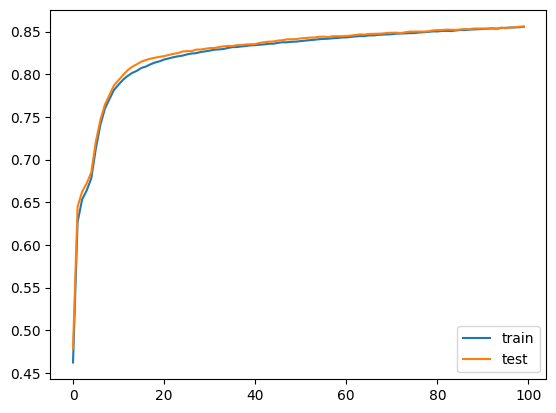

In [13]:
plot_acc(train_accs, test_accs)